# Advanced Time Series Forecasting of Air Quality using LSTM

- Author: Mohammed Houbid
- Date: 02/12/2024

Key Enhancements:
- Robust preprocessing pipeline
- Advanced feature engineering
- Comprehensive model evaluation
- Visualization of model performance

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

wb_token = user_secrets.get_secret("wandb")
wandb.login(key=wb_token)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
class AirQualityForecaster:
    def __init__(self, data_path, seq_length=24, batch_size=64, lr=0.001, epochs=20):
        self.data_path = data_path
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs

        # Initialize wandb
        wandb.init(project="water-quality-prediction", name="enhanced-lstm")

        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.train_loader = None
        self.test_loader = None

    def load_data(self):
        data = pd.read_csv(self.data_path, delimiter=';', parse_dates=['Date'], dayfirst=True)
        data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
        data = data[data['NO2(GT)'] >= 0].dropna()
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        return data

    def preprocess_data(self, data):
        scaled_no2 = self.scaler.fit_transform(data['NO2(GT)'].values.reshape(-1, 1))
        dataset = self.TimeSeriesDataset(scaled_no2, self.seq_length)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    class TimeSeriesDataset(Dataset):
        def __init__(self, data, seq_length):
            self.data = data
            self.seq_length = seq_length

        def __len__(self):
            return len(self.data) - self.seq_length

        def __getitem__(self, index):
            x = self.data[index:index + self.seq_length]
            y = self.data[index + self.seq_length]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    class EnhancedLSTMModel(nn.Module):
        def __init__(self, input_size, output_size):
            super().__init__()
            # First LSTM layer with L1 and L2 regularization
            self.lstm1 = nn.LSTM(input_size, 50, batch_first=True)
            self.dropout1 = nn.Dropout(0.3)

            # Second LSTM layer with L1 and L2 regularization
            self.lstm2 = nn.LSTM(50, 25, batch_first=True)
            self.dropout2 = nn.Dropout(0.3)

            # Fully connected layer
            self.fc = nn.Linear(25, output_size)

        def forward(self, x):
            x, _ = self.lstm1(x)
            x = self.dropout1(x)
            x, (hn, _) = self.lstm2(x)
            x = self.dropout2(hn[-1])  # Use the last hidden state
            out = self.fc(x)
            return out

    def build_model(self):
        self.model = self.EnhancedLSTMModel(input_size=1, output_size=1)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)  # L2 regularization

    def train(self):
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0
            for x_batch, y_batch in tqdm(self.train_loader, desc=f"Epoch {epoch + 1}/{self.epochs}"):
                x_batch = x_batch.view(-1, self.seq_length, 1)
                self.optimizer.zero_grad()
                y_pred = self.model(x_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            wandb.log({"epoch": epoch + 1, "loss": epoch_loss / len(self.train_loader)})
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(self.train_loader):.4f}")

    def evaluate(self):
        self.model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for x_batch, y_batch in self.test_loader:
                x_batch = x_batch.view(-1, self.seq_length, 1)
                y_pred = self.model(x_batch)
                predictions.extend(y_pred.numpy())
                actuals.extend(y_batch.numpy())

        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        actuals = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        wandb.log({"RMSE": rmse, "MAE": mae ,"R2":r2})
        print(f"Test RMSE: {rmse:.2f}, Test MAE: {mae:.2f} , Test R2: {r2:.2f}")

        plt.figure(figsize=(10, 6))
        plt.plot(actuals, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.legend()
        plt.title('Actual vs Predicted')
        plt.show()
        wandb.log({"actual_vs_predicted": wandb.Image(plt)})

    def run_pipeline(self):
        data = self.load_data()
        self.preprocess_data(data)
        self.build_model()
        self.train()
        self.evaluate()

wandb: Currently logged in as: med-houbid (med-houbid-enset-mohammedia). Use `wandb login --relogin` to force relogin


Epoch 1/20: 100%|██████████| 97/97 [00:01<00:00, 67.02it/s]


Epoch 1, Loss: 0.0283


Epoch 2/20: 100%|██████████| 97/97 [00:01<00:00, 86.37it/s]


Epoch 2, Loss: 0.0155


Epoch 3/20: 100%|██████████| 97/97 [00:01<00:00, 83.95it/s]


Epoch 3, Loss: 0.0124


Epoch 4/20: 100%|██████████| 97/97 [00:01<00:00, 86.81it/s]


Epoch 4, Loss: 0.0100


Epoch 5/20: 100%|██████████| 97/97 [00:01<00:00, 86.13it/s]


Epoch 5, Loss: 0.0080


Epoch 6/20: 100%|██████████| 97/97 [00:01<00:00, 83.82it/s]


Epoch 6, Loss: 0.0070


Epoch 7/20: 100%|██████████| 97/97 [00:01<00:00, 85.39it/s]


Epoch 7, Loss: 0.0063


Epoch 8/20: 100%|██████████| 97/97 [00:01<00:00, 85.33it/s]


Epoch 8, Loss: 0.0060


Epoch 9/20: 100%|██████████| 97/97 [00:01<00:00, 81.09it/s]


Epoch 9, Loss: 0.0057


Epoch 10/20: 100%|██████████| 97/97 [00:01<00:00, 86.84it/s]


Epoch 10, Loss: 0.0055


Epoch 11/20: 100%|██████████| 97/97 [00:01<00:00, 77.77it/s]


Epoch 11, Loss: 0.0052


Epoch 12/20: 100%|██████████| 97/97 [00:01<00:00, 68.55it/s]


Epoch 12, Loss: 0.0051


Epoch 13/20: 100%|██████████| 97/97 [00:01<00:00, 85.47it/s]


Epoch 13, Loss: 0.0049


Epoch 14/20: 100%|██████████| 97/97 [00:01<00:00, 86.96it/s]


Epoch 14, Loss: 0.0050


Epoch 15/20: 100%|██████████| 97/97 [00:01<00:00, 89.00it/s]


Epoch 15, Loss: 0.0049


Epoch 16/20: 100%|██████████| 97/97 [00:01<00:00, 86.32it/s]


Epoch 16, Loss: 0.0047


Epoch 17/20: 100%|██████████| 97/97 [00:01<00:00, 84.83it/s]


Epoch 17, Loss: 0.0047


Epoch 18/20: 100%|██████████| 97/97 [00:01<00:00, 80.03it/s]


Epoch 18, Loss: 0.0045


Epoch 19/20: 100%|██████████| 97/97 [00:01<00:00, 85.44it/s]


Epoch 19, Loss: 0.0047


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 84.97it/s]


Epoch 20, Loss: 0.0046
Test RMSE: 19.97, Test MAE: 15.19 , Test R2: 0.83


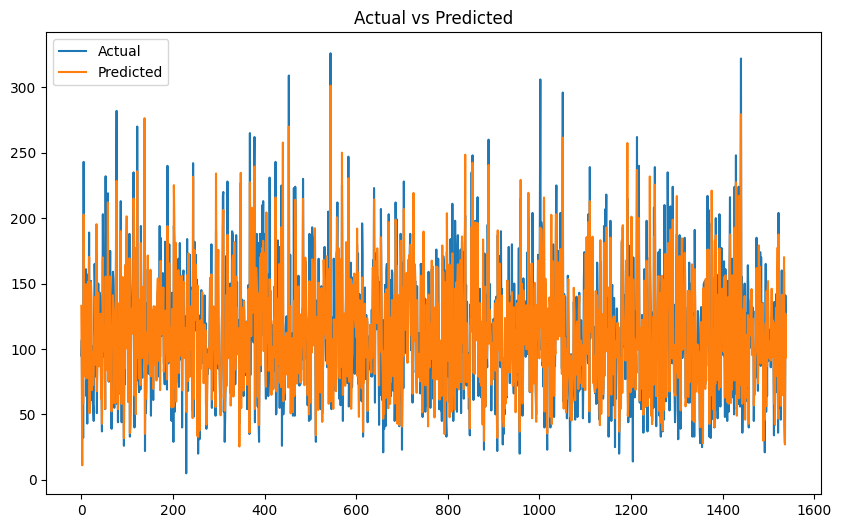

<Figure size 640x480 with 0 Axes>

In [6]:
# Example usage
forecaster = AirQualityForecaster(data_path='/kaggle/input/airqaulity/AirQualityUCI.csv')
forecaster.run_pipeline()